## **FINAL PROJECT FINTECH**
## GROUP 14 - CASE STUDY 1

by Lazzarelli Chiara, Polidori Alberto, Rizzo Giovanni, Shubhankar Kumar

In [ ]:
# Importing necessary packages
import pandas as pd # python's data handling package
import numpy as np # python's scientific computing package
import matplotlib.pyplot as plt # python's plotting package
import seaborn as sns # for plots
import random
import scipy.spatial.distance as ssd

from sklearn.metrics import mean_squared_error as mse #sklearn metric
from sklearn.preprocessing import MinMaxScaler #sklearn min-max scaler
from sklearn.ensemble import IsolationForest #sklearn isolation forest
from scipy.cluster.hierarchy import dendrogram, linkage #sklearn hierarchical clustering tools
from sklearn.cluster import AgglomerativeClustering #sklearn clustering

!pip install minisom
from minisom import MiniSom # for self-organizing map

!pip install gower
import gower # for Gower distance matrix

random.seed(14)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing data
# This code works for Code and Data files both in the same Google Drive folder
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Fintech/CaseStudy1
df = pd.read_excel('BankClients.xlsx')
df.head()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Fintech/CaseStudy1


,ID,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,1,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,2,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,3,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,4,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,5,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


### CLEANING DATA, FEATURE CORRELATION, OUTLIER ANALYSIS

In [ ]:
# Cleaning Data
#min-max scaling only the age, the other data are already in [0,1]
min_age = min(df['Age'])
max_age = max(df['Age'])
df['Age']=(df['Age'] - min_age)/(max_age - min_age)

#removing ID and NA's
df = df.drop('ID',axis=1)
df = df.dropna()

#removing duplicates
df.drop_duplicates()

# later on we will categorize categorical variables, but by doing so we cannot do the mean of the categorical variable
# so we create a copy where categorical variable are still of numeric type
# we also create a copy where we add the labels for the plot
df_all_numerics = df.copy()

In [ ]:
# Setting the category type for categorical variables
df['Gender'] = pd.Categorical(df['Gender'])
df['Job'] = pd.Categorical(df['Job'])
df['Area'] = pd.Categorical(df['Area'])
df['CitySize'] = pd.Categorical(df['CitySize'])
df['FamilySize'] = pd.Categorical(df['FamilySize'])
df['Investments'] = pd.Categorical(df['Investments'])

df.dtypes

# we create a copy for plot
df_plot = df.copy()

<ipython-input-78-9420d6d30cf5>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


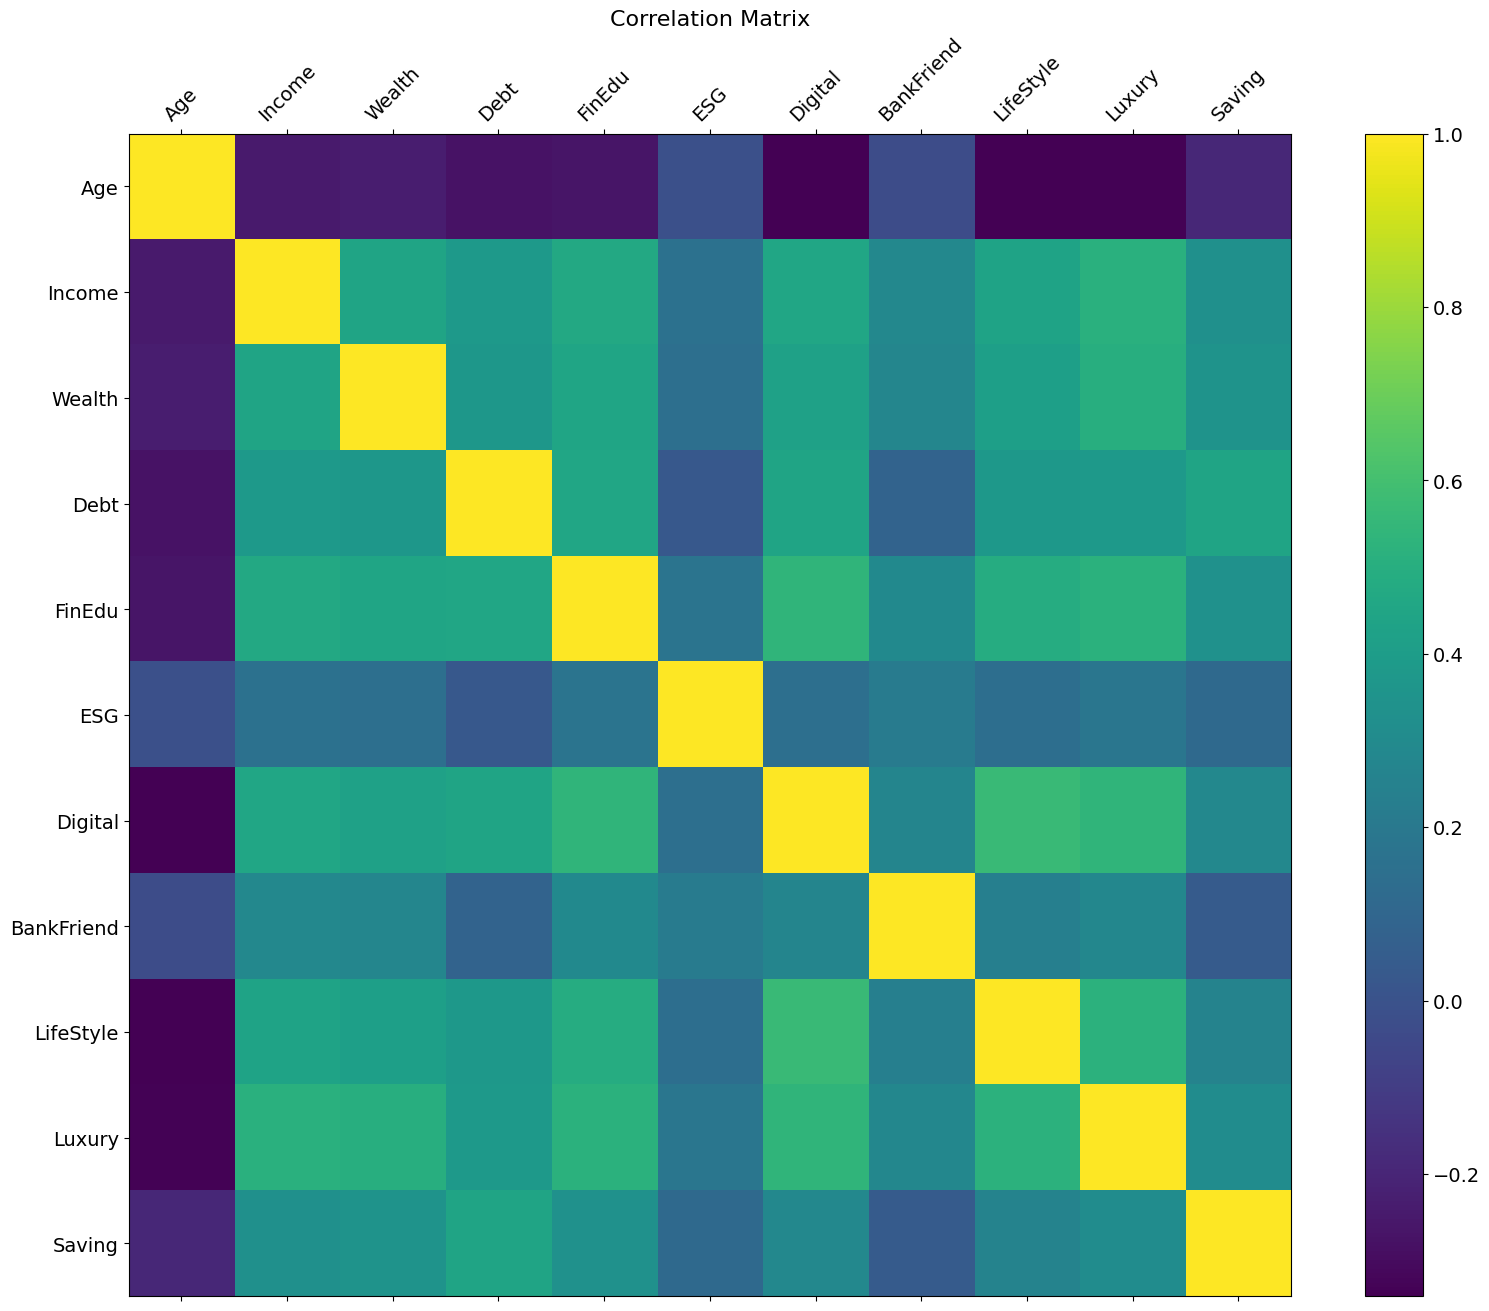

In [ ]:
# Correlation analysis
# Corr-plot
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


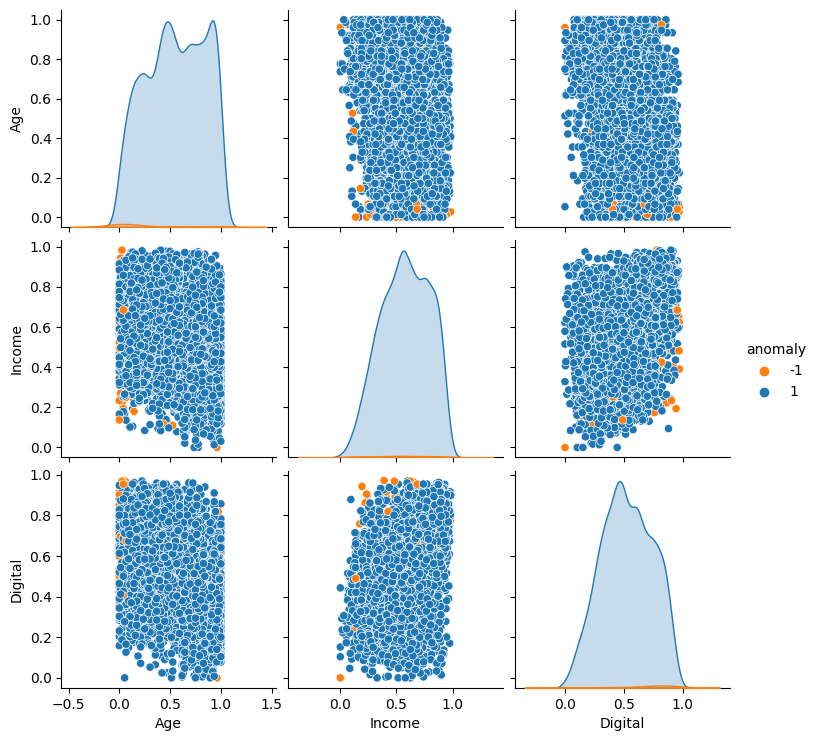

In [ ]:
# Outlier analysis
# Isolation forest

#we expect 1% of the data to be outliers
model_IF = IsolationForest(contamination=float(0.01),random_state=42)
model_IF.fit(df)

anomaly_scores = model_IF.decision_function(df)
anomaly = model_IF.predict(df)
df_plot['anomaly'] = anomaly


#Plot
palette = ['#ff7f0e', '#1f77b4']
anomaly_inputs = ['Age','Income','Digital']
sns.pairplot(df_plot, vars= anomaly_inputs, hue='anomaly', palette=palette)

The data were already cleaned, so we used the entire dataset. Numerical variables were already in [0,1] so we standardized only 'Age'.

As one may expect, Financial Education, Wealth, Income are highly correlated. We decided to use them all but always keep this in mind in our future analysis.

We used the Isolation Forest to analyze the outliers. As expected, the outlier points have the lowest/highest percentiles. Since the most peculiar clients are usually the wealthiest ones, we kept them all. Our goal was only to eventually detect the so called 'Fat-Finger' errors.

## Hierarchical Clustering without categorical features

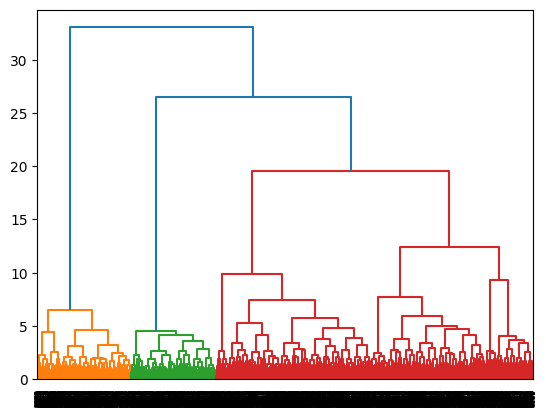

In [ ]:
# Hierarchical Clustering without categorical
# we create a deep copy of the df, otherwise when we drop the column, we drop also in the original df ('=' passes the reference)
df_copy = df.copy()
df_wo_cat = df_copy.drop(['Gender','Job','Area','CitySize','FamilySize', 'Investments'], axis=1);
linkage_df_wo_cat = linkage(df_wo_cat, method='ward', metric='euclidean');
dendrogram(linkage_df_wo_cat);
plt.show()

As we can see, 4 seems to be a good cut.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


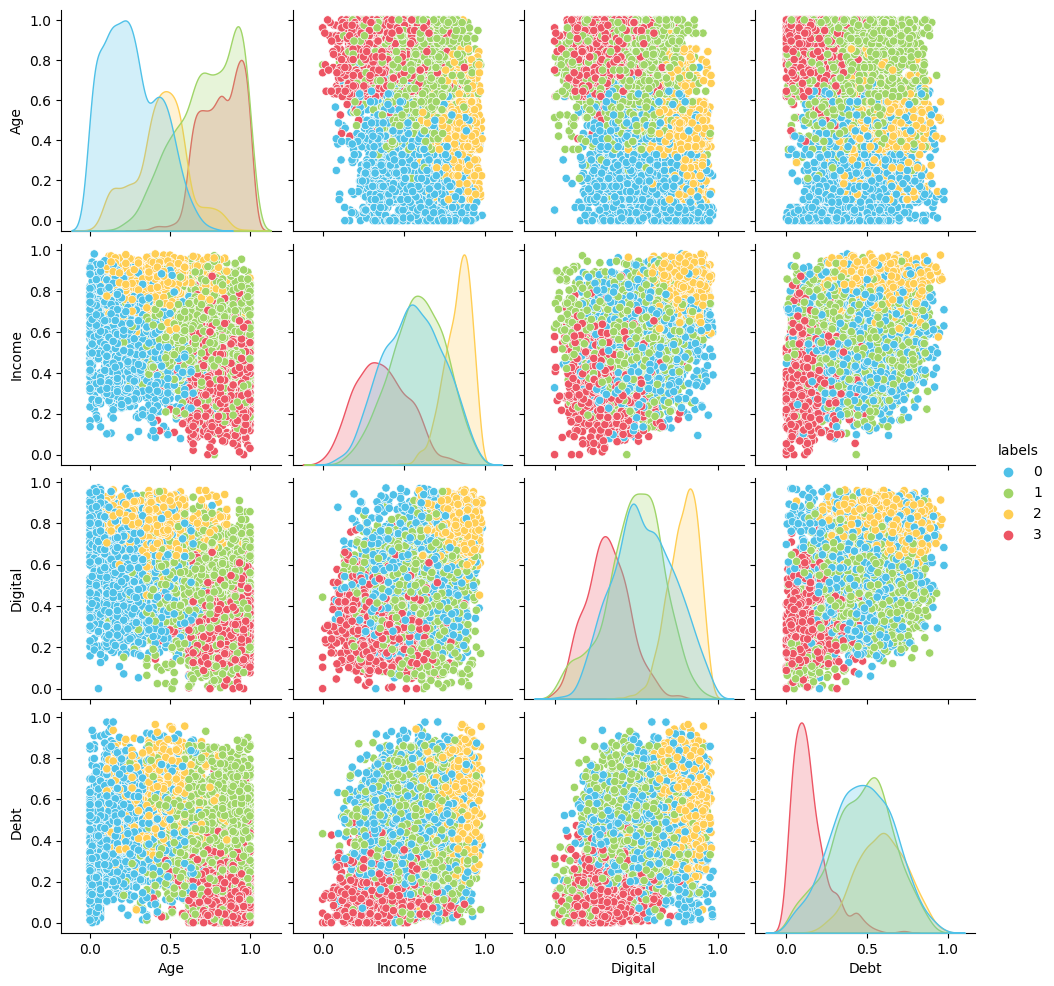

In [ ]:
# we chose Euclidian distance, Ward method
hierarchical_cluster_wo_cat = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster_wo_cat.fit_predict(df_wo_cat)

df_wo_cat['labels'] = labels;
palette =['#4fc1e8','#a0d568','#ffce54','#ed5564'];
sns.pairplot(df_wo_cat, vars= ['Age','Income', 'Digital','Debt'], hue='labels', palette = palette)

In [ ]:
# summary table for the 4 clusters
df_grouped = df_all_numerics.groupby(labels).mean(numeric_only = False)
print(df_grouped)

        Age    Gender       Job      Area  CitySize  FamilySize    Income  \
0  0.259955  0.566809  2.133008  1.382550  1.896888    2.588774  0.556517   
1  0.735049  0.550771  2.163882  1.431234  1.741645    2.765424  0.584166   
2  0.444317  0.386946  2.101399  1.238928  2.614219    2.106061  0.830456   
3  0.819402  0.552270  3.855333  1.445618  1.657867    2.205913  0.364909   

     Wealth      Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle  \
0  0.556388  0.472667  0.507542  0.576033  0.548346    0.563524   0.492517   
1  0.594784  0.467539  0.487263  0.546687  0.487449    0.581690   0.422173   
2  0.832185  0.589459  0.750355  0.674262  0.785936    0.796873   0.702213   
3  0.364014  0.147164  0.339201  0.594358  0.323390    0.615523   0.259103   

     Luxury    Saving  Investments  
0  0.481681  0.552875     2.213545  
1  0.441800  0.580012     2.215938  
2  0.793093  0.597814     2.372960  
3  0.229744  0.299905     1.862724  


As one can see from the table the groups are not so good, for istance 0 and 1 only differ for the age, and categorical variables are not taken into account, when instead they are relevent to match client needs.
Let's try with categorical data.

## Hierarchical Clustering with categorical features

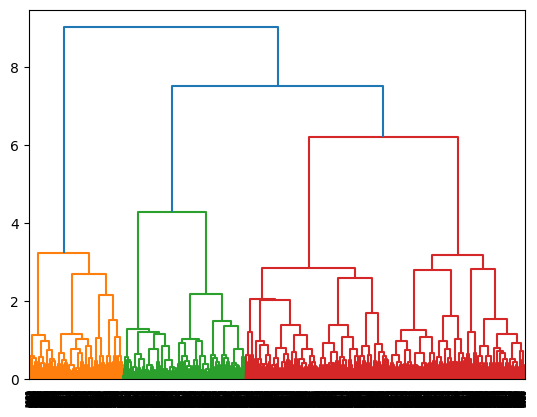

In [ ]:
# Hierarchical Clustering with categorical
# we chose Gower distance, Ward method
df_copy = df.copy()
X = np.asarray(df_copy)
distMatrix = gower.gower_matrix(X);
distArray = ssd.squareform(distMatrix);
linkage_df = linkage(distArray, method='ward', metric='euclidean');
dendrogram(linkage_df);
plt.show()

We chose 4 clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


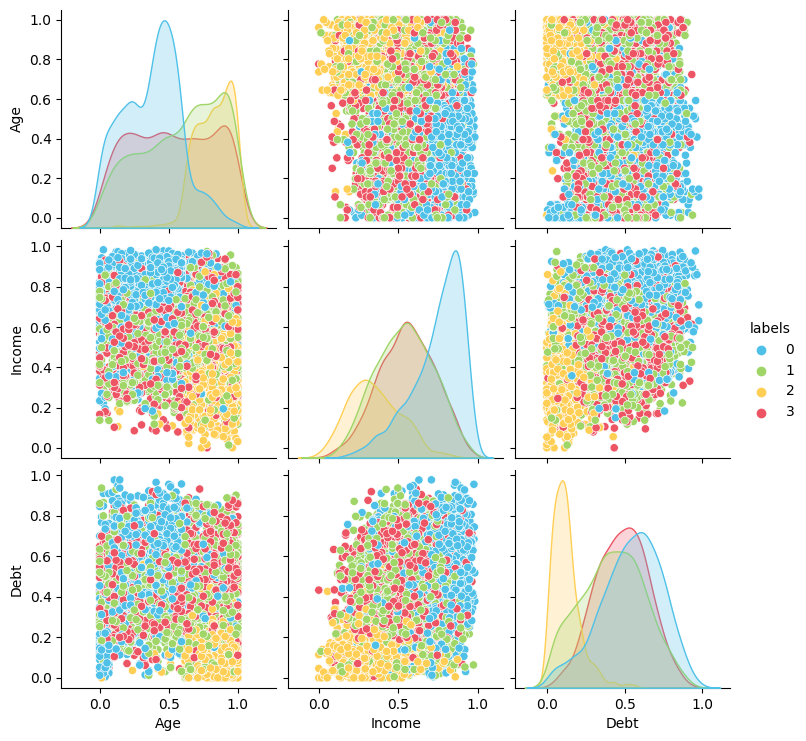

In [ ]:
#some plots
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(distMatrix)
df_plot['labels'] = labels

palette =['#4fc1e8','#a0d568','#ffce54','#ed5564'];
sns.pairplot(df_plot, vars= ['Age','Income','Debt'], hue='labels', palette = palette)

In [ ]:
# summary table for the 4 clusters
df_grouped = df_all_numerics.groupby(labels).mean(numeric_only = False)
print(df_grouped)

        Age    Gender       Job      Area  CitySize  FamilySize    Income  \
0  0.379018  0.583219  2.131362  1.259285  2.596974    2.014443  0.744555   
1  0.590941  1.000000  2.170698  1.422944  1.632343    2.795439  0.540488   
2  0.819688  0.474623  4.440329  1.480110  1.637860    2.128944  0.352299   
3  0.527929  0.000000  2.072993  1.427737  1.678832    2.858394  0.553064   

     Wealth      Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle  \
0  0.739721  0.539867  0.674201  0.663740  0.744367    0.709982   0.675353   
1  0.551250  0.422644  0.457523  0.551128  0.448700    0.576236   0.385696   
2  0.357509  0.123230  0.332605  0.609564  0.310675    0.627978   0.256006   
3  0.556425  0.482441  0.489255  0.532266  0.496154    0.563080   0.427235   

     Luxury    Saving  Investments  
0  0.722834  0.580941     2.277166  
1  0.406066  0.538493     2.243953  
2  0.218143  0.282041     1.709191  
3  0.421427  0.566496     2.242336  


This 4 groups are better than the four ones clustered without categoricals.

However there are two problems:

a) 'Investment' is a feature that should be relevant in order to catch differences in clients' behaviour, but these 4 groups have all more or less the same mean value

b) Groups 1 and 3 only deffer for gender (1 = all females, 3 = all males) so they have same Wealth, Savings, Investment (and so they will have the same needs).

Since we thought that also 'Area' may not be a relevant feature, we decided to try the same procedure without 'Gender' and 'Area'.

## Hierarchical Clustering with all categoricals except 'Gender' and 'Area'

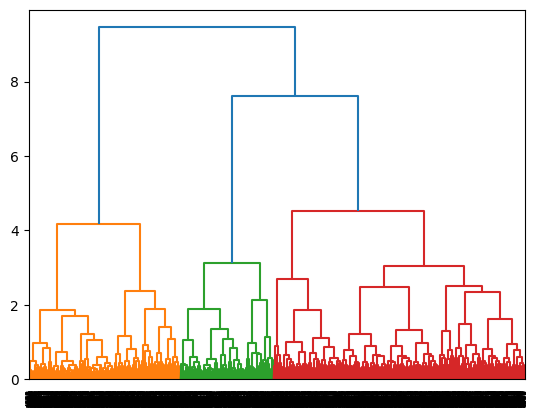

In [ ]:
# Hierarchical clustering with categoricals, no 'Gender' and 'Area'
# As done above, we used Gower distance and Ward method

df_copy = df.copy()
X = np.asarray(df_copy.drop(['Gender', 'Area'], axis = 1))

distMatrix = gower.gower_matrix(X);
distArray = ssd.squareform(distMatrix);
linkage_df = linkage(distArray, method='ward', metric='euclidean');
dendrogram(linkage_df);
plt.show()

The natural cut here would be 3. However, we thought that 3 cluster would have too generic mean characteristic.

So we tried with 5, in order to catch more differences between groups.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


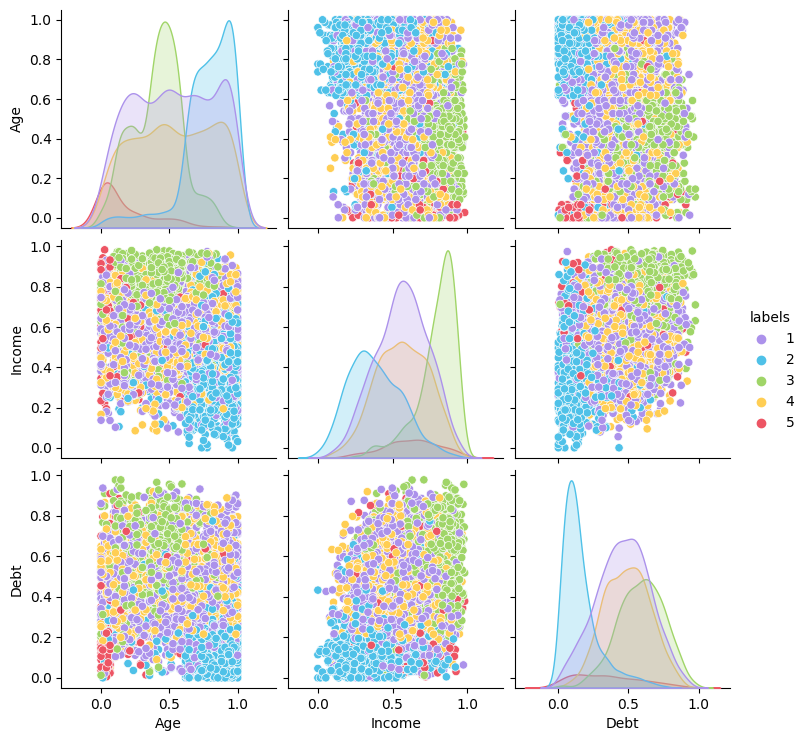

In [ ]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(distMatrix) + 1

# labels = labels + 1 so that the first cluster is #1
df_plot['labels'] = labels
palette =['#ac92eb','#4fc1e8','#a0d568','#ffce54','#ed5564'];
sns.pairplot(df_plot, vars= ['Age','Income','Debt'], hue='labels', palette = palette)

In [ ]:
# summary table for the 5 clusters
df_grouped = df_all_numerics.groupby(labels).mean(numeric_only = False)
print(df_grouped)

print('\nMEAN AGE:')
print(df_grouped['Age']*(max_age - min_age) + min_age)

        Age    Gender       Job      Area  CitySize  FamilySize    Income  \
1  0.535633  0.547414  2.048030  1.407020  1.746305    2.740764  0.561890   
2  0.781033  0.573011  4.073515  1.438066  1.626385    2.227593  0.382699   
3  0.411480  0.448242  2.157227  1.227539  2.679688    1.982422  0.792342   
4  0.532934  0.503823  1.968564  1.456245  1.704333    2.829227  0.562320   
5  0.181029  0.719780  2.307692  1.324176  2.368132    2.302198  0.623380   

     Wealth      Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle  \
1  0.561948  0.461339  0.485578  0.555857  0.486972    0.565032   0.424274   
2  0.387246  0.160042  0.344860  0.593177  0.321485    0.615606   0.265557   
3  0.802108  0.586823  0.730143  0.693054  0.775304    0.757597   0.702546   
4  0.569933  0.488281  0.498694  0.545714  0.508838    0.575865   0.438180   
5  0.586991  0.349235  0.491307  0.507730  0.741216    0.620110   0.682095   

     Luxury    Saving  Investments  
1  0.437696  0.564208     2.946

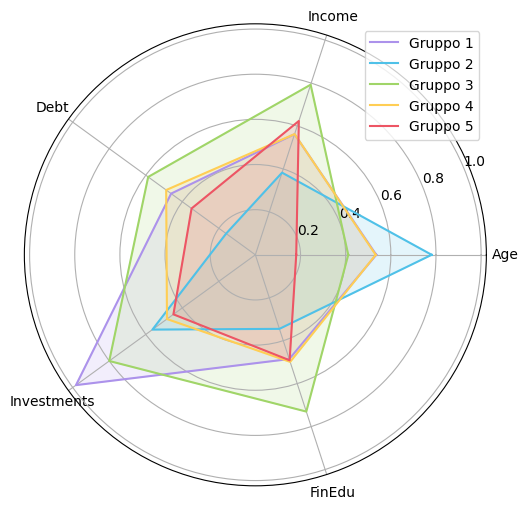

In [ ]:
# Radar plot
parametri = ['Age', 'Income', 'Debt', 'Investments', 'FinEdu']
df_grouped_plot = df_grouped[['Age', 'Income', 'Debt', 'Investments', 'FinEdu']].values.tolist()

limiti_parametri = [(0, 1), (0, 1), (0, 1), (0, 3), (0, 1)]

# Normalizza i valori dei parametri
gruppi_normalizzati = []
for gruppo in df_grouped_plot:
    gruppo_normalizzato = []
    for valore, limite in zip(gruppo, limiti_parametri):
        valore_normalizzato = (valore - limite[0]) / (limite[1] - limite[0])
        gruppo_normalizzato.append(valore_normalizzato)
    gruppi_normalizzati.append(gruppo_normalizzato)

# Calcola gli angoli per il radar plot
numero_parametri = len(parametri)
angoli = np.linspace(0, 2*np.pi, numero_parametri, endpoint=False).tolist()
angoli += angoli[:1]

# Crea il grafico a radar
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Disegna i grafici dei gruppi normalizzati

palette =['#4fc1e8','#a0d568','#ffce54','#ed5564','#ac92eb'];
for i, gruppo in enumerate(gruppi_normalizzati):
    gruppo += gruppo[:1]  # Estendi la forma chiusa
    ax.plot(angoli, gruppo, label='Gruppo {}'.format(i+1), color = palette[i-1])
    ax.fill(angoli, gruppo, alpha=0.15, color = palette[i-1])

ax.set_xticks(angoli[:-1])
ax.set_xticklabels(parametri)
ax.legend()
plt.show()

We are quite satisfied with the five cluster which are clearly distinguishable:

Group 3 are very wealthy people, with the highest income. They have the highest debts but this is ok since they're likely to pay back.

Group 2 are retired old people, with little debts.

Group 5 are very young people, 30 years mean age, mainly women (70% , notice that however 'Gender' was not used for cluseting) with a good wage.
Can be ex college students with some remaining debt.

Group 1 and 4 are people of all kind of age, they probably have family (higher avarege of number of family member), they have standard wages. Their difference stands only in their investment attitude.

We decided to keep these as our clusters.



## Final check: SOM

After having selected the clusters, we want to do a check with SOM.

The idea is the following: we build a (2,2) grid, so we have 4 potential clusters.

We want to check that the characteristics of the SOM clusters are in some sense similar to the ones we chose.

In [ ]:
df_copy = df_all_numerics.copy()

# we drop 'Gender'
data = np.array(df_copy.drop(['Gender', 'Area'], axis = 1))
# min max scaled all data
data = MinMaxScaler().fit_transform(data)

som_shape = (2,2)

som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=0.5, learning_rate=0.3,
              neighborhood_function='gaussian', random_seed=14)

som.train_batch(data, 2000, verbose=True)

 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 0.785266019186237


In [ ]:
# Each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T

# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape) + 1

# summary table
print(df_all_numerics.groupby(cluster_index).mean(numeric_only = False))

        Age    Gender       Job      Area  CitySize  FamilySize    Income  \
1  0.571607  0.536364  1.830579  1.449587  1.755372    2.755372  0.527894   
2  0.396296  0.506033  2.165366  1.259049  2.758694    1.984386  0.737145   
3  0.535841  0.511656  2.041718  1.424540  1.462577    2.909816  0.557795   
4  0.803665  0.592543  4.957390  1.431425  1.647137    2.089214  0.389611   

     Wealth      Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle  \
1  0.538389  0.408875  0.456380  0.542361  0.471928    0.582334   0.407534   
2  0.734692  0.536483  0.668585  0.666543  0.725852    0.708829   0.655336   
3  0.562108  0.486413  0.490538  0.537605  0.496560    0.561656   0.428240   
4  0.390510  0.138236  0.347854  0.618407  0.312437    0.634461   0.262968   

     Luxury    Saving  Investments  
1  0.406140  0.511149     1.264463  
2  0.708138  0.584303     2.404542  
3  0.426957  0.569722     2.826380  
4  0.252761  0.313149     1.798935  


As on can see, here we find again retired people (g4), younger and wealtier (g2) and middle class (g1) and (g3) whose only difference is their approach in investments.

These results are in some sense consistent with the ones of hierarchical model.

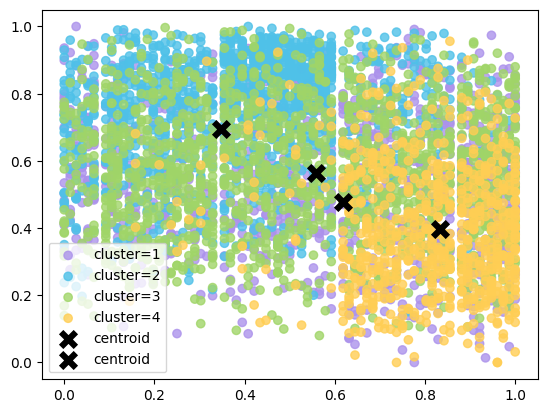

In [ ]:
# plotting the clusters using Age vs Income

palette=['#ac92eb','#4fc1e8','#a0d568','#ffce54']

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
        data[cluster_index == c, 4], label='cluster='+str(c), alpha=.8, color = [palette[c-1]]*np.shape(data[cluster_index == c, 0])[0])

for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 4], marker='x',
                s=10, linewidths=15, color='k', label='centroid')
plt.legend()